<a href="https://colab.research.google.com/github/dotimothy/Classifiers/blob/main/CIFAR10/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Dataset Notebook
This notebook explores the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset [1] and how to use it in Python with different classification architectures learned in C147/247 at UCLA. As a summary, the CIFAR-10 dataset is a labeled subset of the [80 Million Tiny Images](https://groups.csail.mit.edu/vision/TinyImages/) dataset with 60,000 images and 10 classes.

**Author:** [Timothy Do](https://timothydo.me)

## Citations
[1] A. Krizhevsky, ‘Learning Multiple Layers of Features from Tiny Images’, 2009.

## Dependencies

In [ ]:
# Checking if Environment is Google CoLab
IN_COLAB = True
try: 
    import google.colab
except:
    IN_COLAB = False
print(f'In CoLab: {IN_COLAB}')
if(IN_COLAB):
    !curl https://raw.githubusercontent.com/dotimothy/Classifiers/main/requirements.txt -o ./requirements.txt

In [5]:
if(IN_COLAB):
    !pip install -r ./requirements.txt
else:
    !pip install -r ../requirements.txt

In [3]:
# Libraries
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class bold:
   START = '\033[1m'
   END = '\033[0m'

## Loading Data and Visualizing It

In [4]:
# Downloading the Data
dataPath = '../data/CIFAR10'
cifar10Tar = f'{dataPath}/cifar-10.tar.gz'
cifar10Dir = f'{dataPath}/cifar-10-python'
os.makedirs(dataPath,exist_ok=True)
if(not(os.path.exists(cifar10Tar))):
  os.system(f'curl https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -o {cifar10Tar}')
if(not(os.path.exists(cifar10Dir))):
  os.mkdir(cifar10Dir)
  os.system(f'tar -xf {cifar10Tar} -C {cifar10Dir}')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  7318k      0  0:00:22  0:00:22 --:--:-- 9020k


In [3]:
# Loads a CIFAR10 Batch
def load_CIFAR10_batch(file):
  with open(file,'rb') as f:
    datadict = pickle.load(f,encoding='bytes')
    X = datadict[b'data']
    Y = datadict[b'labels']
    X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
    Y = np.array(Y)
  return X,Y

# Loads CIFAR10 Dataset
def load_CIFAR10(root):
  xs = []
  ys = []
  for b in range(1,6):
    f =  f'{root}/cifar-10-batches-py/data_batch_{b}'
    X,Y = load_CIFAR10_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X,Y
  Xte, Yte = load_CIFAR10_batch(f'{root}/cifar-10-batches-py/test_batch')
  return Xtr,Ytr,Xte,Yte

# Get Subsets for CIFAR-10
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000,
                     subtract_mean=True):

    # Load the raw CIFAR-10 data
    cifar10_dir = cifar10Dir
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
      mean_image = np.mean(X_train, axis=0)
      X_train -= mean_image
      X_val -= mean_image
      X_test -= mean_image
    
    # Transpose so that channels come first
    # X_train = X_train.transpose(0, 3, 1, 2).copy()
    # X_val = X_val.transpose(0, 3, 1, 2).copy()
    # X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

In [4]:
# Load in the Training and Test Datasets
data = get_CIFAR10_data(subtract_mean=False)
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
Y_train = data['y_train']
Y_val = data['y_val']
Y_test = data['y_test']

# Standard Logistics
print("Training Data Shape: ",X_train.shape)
print("Training Labels Shape: ",Y_train.shape)
print("Validation Data Shape: ",X_val.shape)
print("Validation Labels Shape: ",Y_val.shape)
print("Testing Data Shape: ",X_test.shape)
print("Testing Label Shape: ",Y_test.shape)

Training Data Shape:  (49000, 32, 32, 3)
Training Labels Shape:  (49000,)
Validation Data Shape:  (1000, 32, 32, 3)
Validation Labels Shape:  (1000,)
Testing Data Shape:  (10000, 32, 32, 3)
Testing Label Shape:  (10000,)


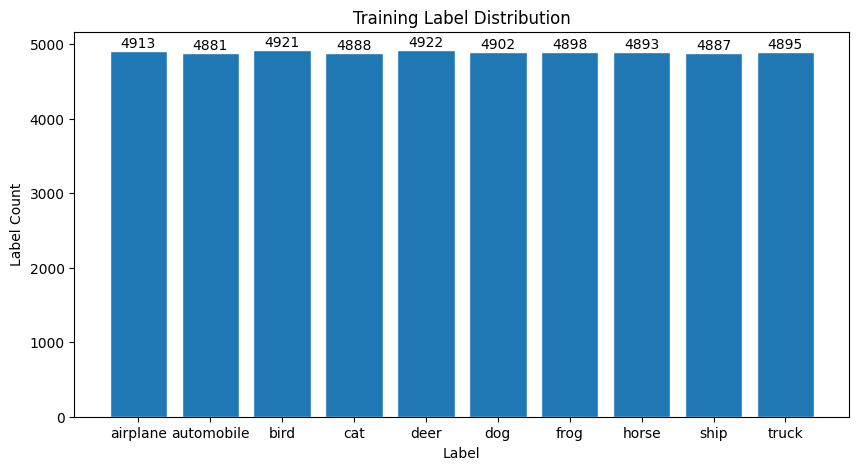

In [5]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Label Distributions for Training Data
plt.figure(figsize=(10,5))
counts, bins = np.histogram(Y_train)
trainTitle = plt.title('Training Label Distribution')
trainXLabel = plt.xlabel('Label')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(classes,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

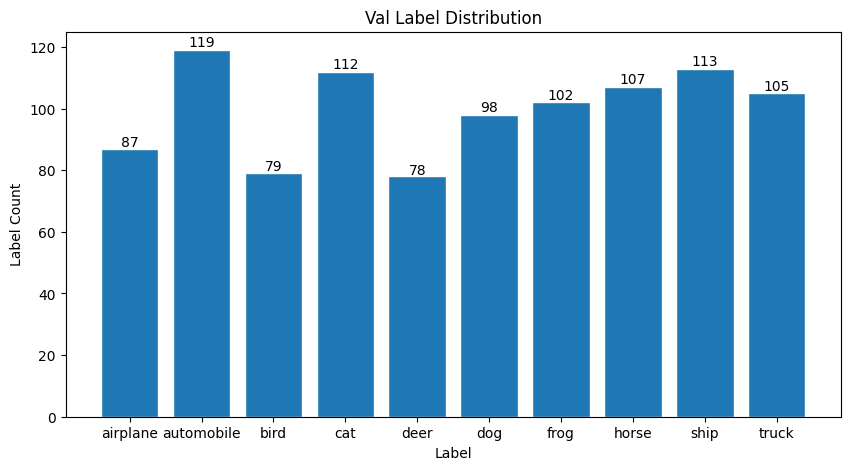

In [6]:
# Label Distributions for Validation Data
plt.figure(figsize=(10,5))
counts, bins = np.histogram(Y_val)
trainTitle = plt.title('Val Label Distribution')
trainXLabel = plt.xlabel('Label')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(classes,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

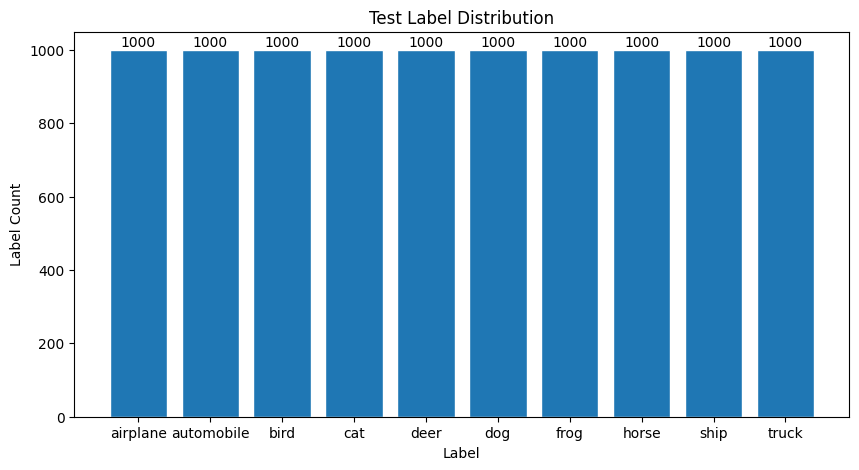

In [7]:
# Label Distributions for Testing Data
plt.figure(figsize=(10,5))
counts, bins = np.histogram(Y_test)
trainTitle = plt.title('Test Label Distribution')
trainXLabel = plt.xlabel('Label')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(classes,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

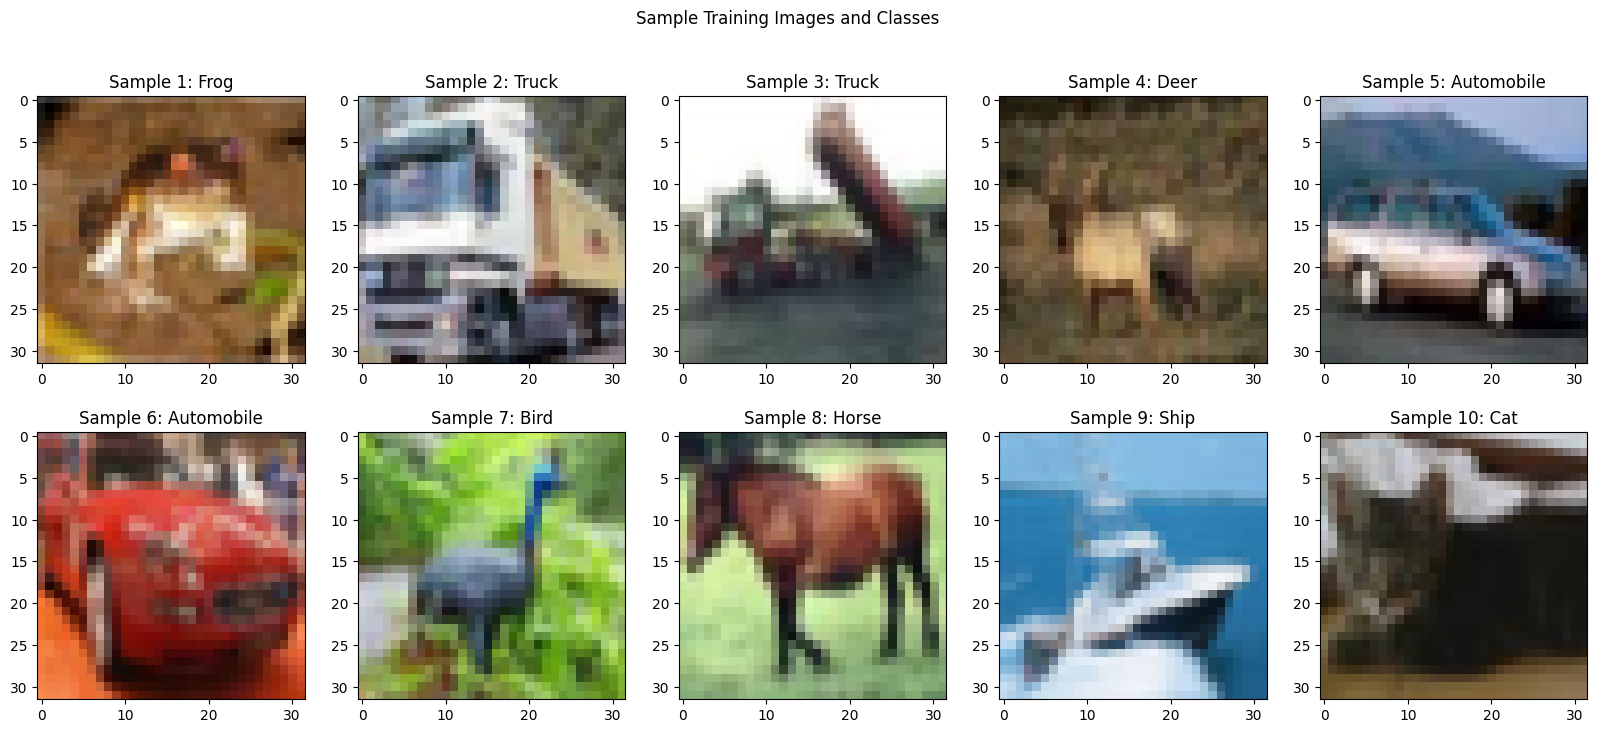

In [8]:
# Visualizing Training Set
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
sampleTitle = fig.suptitle("Sample Training Images and Classes")
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i][j].imshow(X_train[i*cols+j].astype('uint8'))
    ax[i][j].set_title(f'Sample {i*cols+j+1}: {classes[Y_train[i*cols+j]].capitalize()}')

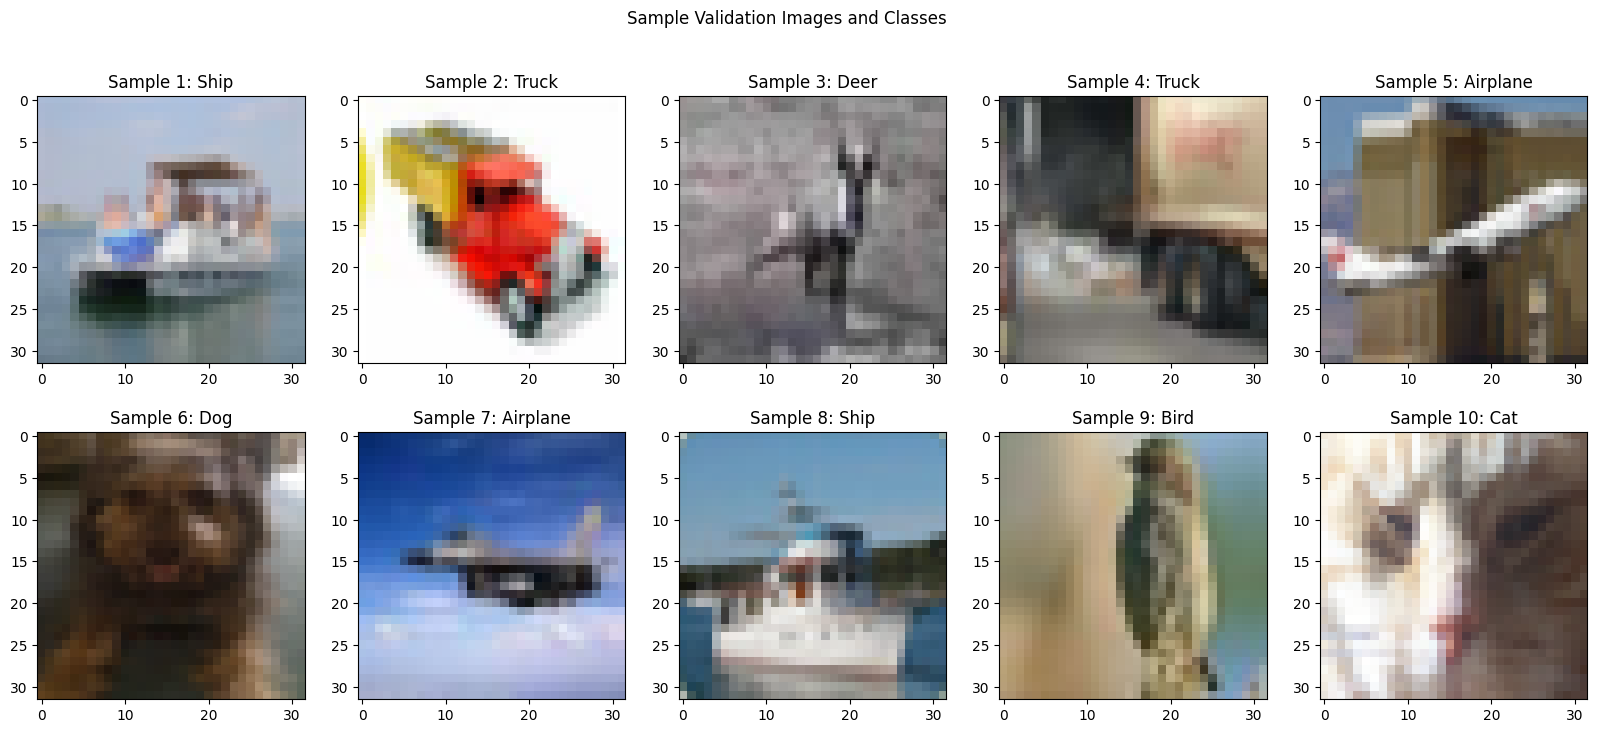

In [9]:
# Visualizing Validation Dataset
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
sampleTitle = fig.suptitle("Sample Validation Images and Classes")
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i][j].imshow(X_val[i*cols+j].astype('uint8'))
    ax[i][j].set_title(f'Sample {i*cols+j+1}: {classes[Y_val[i*cols+j]].capitalize()}')

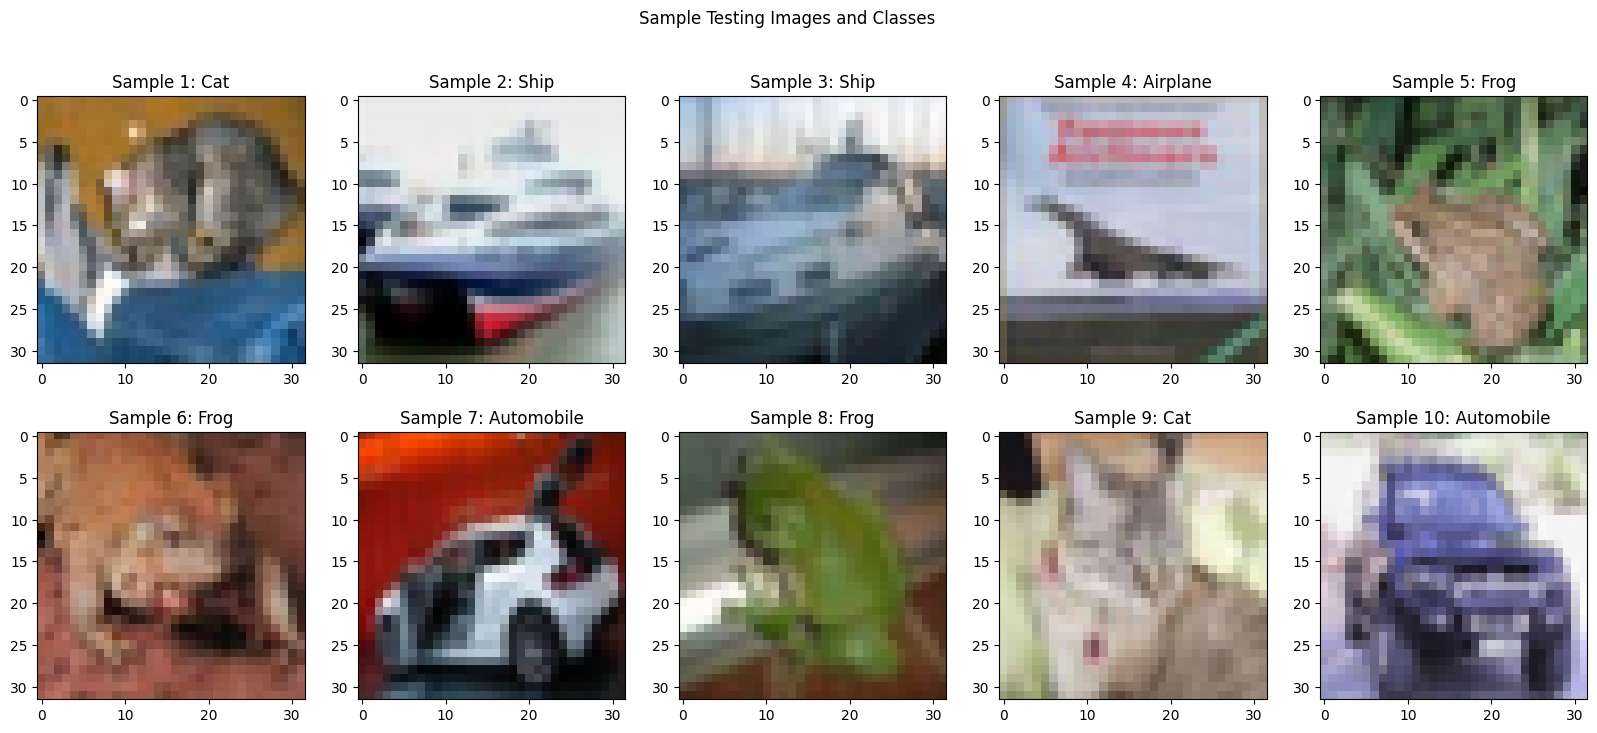

In [10]:
# Visualizing Testing Dataset
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
sampleTitle = fig.suptitle("Sample Testing Images and Classes")
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i][j].imshow(X_test[i*cols+j].astype('uint8'))
    ax[i][j].set_title(f'Sample {i*cols+j+1}: {classes[Y_test[i*cols+j]].capitalize()}')

## Neural Network Architectures

### Device Configuration

In [12]:
# Setup PyTorch Device (Assuming only Single Device)
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
gpuName = f'({torch.cuda.get_device_name(device)})' if torch.cuda.is_available() else ''
print(f'Using PyTorch Backend: {device} {gpuName}')

Using PyTorch Backend: cuda (NVIDIA GeForce RTX 3080)


### 1. Fully Connected Layers (FCNet)

In [6]:
class FCNet(nn.Module):
    """ A Fully Connected Net with Batch Norm and Dropout """
    def __init__(self,input_dim=3072,hidden_dim=500,hidden_layers=1,num_classes=10,p=0.5):
        super(FCNet,self).__init__()

        layers = []

        # Input Layer
        input_layer = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout1d(p=p),
        )
        layers.append(input_layer)

        # Hidden Layer
        hidden_layer = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout1d(p=p),
        )
        for h in range(hidden_layers):
            layers.append(hidden_layer) 

        # Output Layer
        output_layer = nn.Sequential(
            nn.Linear(hidden_dim,num_classes),
            nn.Softmax(dim=1),
        )
        layers.append(output_layer)

        self.model = nn.ModuleList(layers)

    def forward(self,x):
        for layer in self.model:
            x = layer(x)
        return x

print(FCNet())

FCNet(
  (model): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=3072, out_features=500, bias=True)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout1d(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=500, bias=True)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout1d(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=500, out_features=10, bias=True)
      (1): Softmax(dim=1)
    )
  )
)


In [31]:
# Define Model Parameters
model = FCNet(hidden_layers=1,hidden_dim=250).to(device)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Flatten
X_train_flat = X_train.reshape(X_train.shape[0],-1)
X_val_flat = X_val.reshape(X_val.shape[0],-1)
X_test_flat = X_test.reshape(X_test.shape[0],-1)

# Creating Data Tensors & Datasets
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)
train_data = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
valid_data = torch.utils.data.TensorDataset(X_val_tensor,Y_val_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# Creating Data Loaders
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valid_data,shuffle=False,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [37]:
num_epochs = 50
verbose = False
train_accs = []
val_accs = []

# Training Loop
print('Training and Validation')
for epoch_idx in (range(num_epochs) if verbose else tqdm(range(num_epochs))):
    # Training
    model.train()
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # 
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)
    train_acc = train_correct_count / train_count
    train_accs.append(train_acc.cpu().numpy())

    # Validation
    model.eval()
    val_count = 0
    val_correct_count = 0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
    val_acc = val_correct_count / val_count
    val_accs.append(val_acc.cpu().numpy())
    
    if(verbose): print(f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

print(f'Final Train Acc: {train_acc:.3f}, Final Val Acc: {val_acc:.3f}')

# Test
print('\nTesting')
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print(f'Test Acc: {test_acc:.3f}')

Training and Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.18it/s]


Final Train Acc: 0.246, Final Val Acc: 0.538

Testing
Test Acc: 0.511


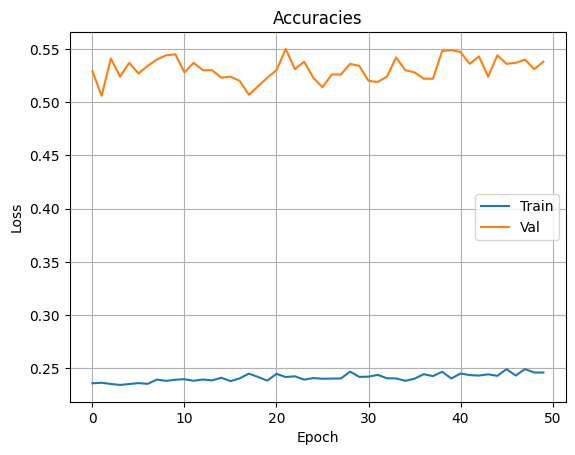

In [40]:
plt.figure()
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_accs)
plt.plot(val_accs)
plt.legend(['Train','Val'])
plt.grid()
plt.show()

### 2. Basic CNN (ConvNet)

In [42]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x
print(ConvNet())

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [43]:
# Define Model Parameters
model = ConvNet().to(device)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

X_train = X_train.transpose((0,3,2,1))
X_val = X_val.transpose((0,3,2,1))
X_test = X_test.transpose((0,3,2,1))

# Creating Data Tensors & Datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)
train_data = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
valid_data = torch.utils.data.TensorDataset(X_val_tensor,Y_val_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# Creating Data Loaders
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valid_data,shuffle=False,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [44]:
num_epochs = 50
verbose = False
train_accs = []
val_accs = []

# Training Loop
print('Training and Validation')
for epoch_idx in (range(num_epochs) if verbose else tqdm(range(num_epochs))):
    # Training
    model.train()
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # 
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)
    train_acc = train_correct_count / train_count
    train_accs.append(train_acc.cpu().numpy())

    # Validation
    model.eval()
    val_count = 0
    val_correct_count = 0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
    val_acc = val_correct_count / val_count
    val_accs.append(val_acc.cpu().numpy())
    
    if(verbose): print(f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

print(f'Final Train Acc: {train_acc:.3f}, Final Val Acc: {val_acc:.3f}')

# Test
print('\nTesting')
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print(f'Test Acc: {test_acc:.3f}')

Training and Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.14it/s]


Final Train Acc: 0.100, Final Val Acc: 0.107

Testing
Test Acc: 0.100


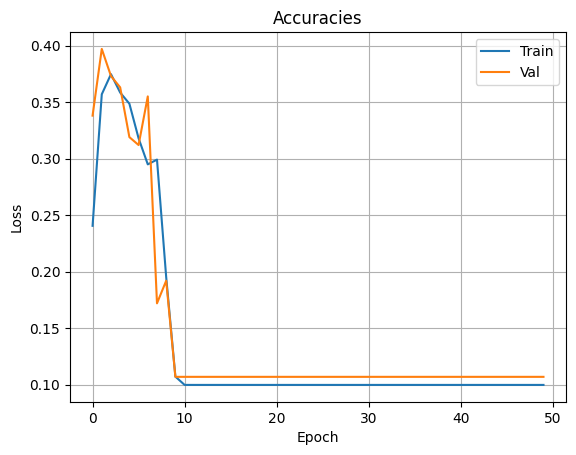

In [45]:
plt.figure()
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_accs)
plt.plot(val_accs)
plt.legend(['Train','Val'])
plt.grid()
plt.show()

### 3. Deep CNN (DeepCNN)

In [46]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [47]:
# Define Model Parameters
model = DeepCNN().to(device)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Creating Data Tensors & Datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)
train_data = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
valid_data = torch.utils.data.TensorDataset(X_val_tensor,Y_val_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# Creating Data Loaders
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valid_data,shuffle=False,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [48]:
num_epochs = 50
verbose = False
train_accs = []
val_accs = []

# Training Loop
print('Training and Validation')
for epoch_idx in (range(num_epochs) if verbose else tqdm(range(num_epochs))):
    # Training
    model.train()
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # 
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)
    train_acc = train_correct_count / train_count
    train_accs.append(train_acc.cpu().numpy())

    # Validation
    model.eval()
    val_count = 0
    val_correct_count = 0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
    val_acc = val_correct_count / val_count
    val_accs.append(val_acc.cpu().numpy())
    
    if(verbose): print(f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

print(f'Final Train Acc: {train_acc:.3f}, Final Val Acc: {val_acc:.3f}')

# Test
print('\nTesting')
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print(f'Test Acc: {test_acc:.3f}')

Training and Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:09<00:00,  4.98s/it]


Final Train Acc: 0.995, Final Val Acc: 0.820

Testing
Test Acc: 0.802


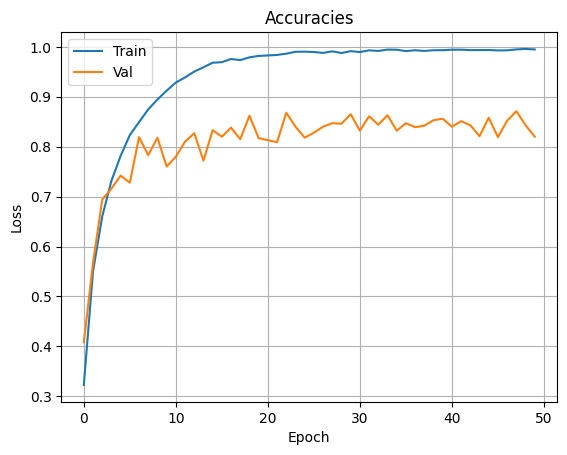

In [49]:
plt.figure()
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_accs)
plt.plot(val_accs)
plt.legend(['Train','Val'])
plt.grid()
plt.show()

In [50]:
torch.cuda.empty_cache()

## Saving and Exporting the Best Model

### PyTorch 

In [51]:
model.eval()
torch.save(model,'./DeepCNNCIFAR10.pt')

### Onnx

In [59]:
dummy = torch.randn(1,3,32,32).to(device)
onnxModel = torch.onnx.export(model,dummy,'DeepCNNCIFAR10.onnx',verbose=True)